In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#Para el preprocesamiento/la preparación de los datos
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

#Test estadísticos
from statsmodels.tsa.stattools import adfuller

#Modelos
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression

#Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#Diagramas
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#disable warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [2]:
data = pd.read_csv('Data/Datos_Prueba_DataScientist.csv')
data.head()

,OrderId,RequestTime,DeliveryOption
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm


In [3]:
level = pd.read_csv('Data/Level_of_affectedness.csv', delimiter=';')
level.head()

,Year,Month,Day,Level of affectedness
0,2018,1,1,0
1,2018,2,1,0
2,2018,3,1,0
3,2018,4,1,0
4,2018,5,1,0


### Some initial formating of the data

In [4]:
#Se observa que unicamente hay 3 valores para la columna DeliveryOption, correspondientes a los 3 
#tipos de opciones de entrega. Esto implica que los podemos codificar directamente sin ninguna extracción de texto
data['DeliveryOption'].value_counts()

Mismo dia entre 6:30 pm y 8:30 pm            86800
Siguiente dia entre 12:30 pm y 2:30 pm       45505
Siguiente dia entre las 6:30 pm y 8:30 pm    20970
Name: DeliveryOption, dtype: int64

In [5]:
#Realizando una funcion para codificar los valores como opcion 1, 2 ó 3
valores_delivery_option = data['DeliveryOption'].value_counts().index
def encode_option(s):
    if s == valores_delivery_option[0]:
        return 1
    if s == valores_delivery_option[1]:
        return 2
    if s == valores_delivery_option[2]:
        return 3
    return -1

data['numericDeliveryOption'] = data['DeliveryOption'].apply(lambda x: encode_option(x))
data['numericDeliveryOption'].value_counts()

1    86800
2    45505
3    20970
Name: numericDeliveryOption, dtype: int64

In [6]:
#transformando la columna RequestTime a formato fecha de pandas
data['RequestTime'] =  pd.to_datetime(data['RequestTime'])
data['RequestTime']

0        2018-01-01 08:03:12
1        2018-01-01 08:28:55
2        2018-01-01 08:39:08
3        2018-01-01 09:25:07
4        2018-01-01 09:36:25
                 ...        
153270   2021-02-28 17:19:26
153271   2021-02-28 17:19:37
153272   2021-02-28 17:43:56
153273   2021-02-28 17:53:28
153274   2021-02-28 17:53:41
Name: RequestTime, Length: 153275, dtype: datetime64[ns]

In [7]:
level['Date'] = level.apply(lambda x: pd.Timestamp(x['Year'], x['Month'], x['Day']), axis=1)
level['Date']

0    2018-01-01
1    2018-02-01
2    2018-03-01
3    2018-04-01
4    2018-05-01
5    2018-06-01
6    2018-07-01
7    2018-08-01
8    2018-09-01
9    2018-10-01
10   2018-11-01
11   2018-12-01
12   2019-01-01
13   2019-02-01
14   2019-03-01
15   2019-04-01
16   2019-05-01
17   2019-06-01
18   2019-07-01
19   2019-08-01
20   2019-09-01
21   2019-10-01
22   2019-11-01
23   2019-12-01
24   2020-01-01
25   2020-02-01
26   2020-03-01
27   2020-04-01
28   2020-05-01
29   2020-06-01
30   2020-07-01
31   2020-08-01
32   2020-09-01
33   2020-10-01
34   2020-11-01
35   2020-12-01
36   2021-01-01
37   2021-02-01
38   2021-03-01
Name: Date, dtype: datetime64[ns]

### Exploratory Data Analysis

In [8]:
#En primer lugar se hará una división de los datos, asegurar de que los resultados del modelo generalicen bien.
#En particular es necesario que el exploratory data analysis se haga unicamente con los datos de entrenamiento para
#evitar algun sobreajuste de los datos no esperado. Se va a hacer un corte temporal de los datos para que no haya ningún
#filtrado de datos por tiempo (en particular que no estemos utilizando los datos futuros para predecir los pasados)
train = data[data['RequestTime'] < pd.to_datetime('2021-01-01 00:00:00')]
test = data[data['RequestTime'] >= pd.to_datetime('2021-01-01 00:00:00')]
print("Numero de registros en el conjunto de entrenamiento: {}\nNumero de datos en el conjunto de pruebas: {}".format(len(train), len(test)))

Numero de registros en el conjunto de entrenamiento: 139649
Numero de datos en el conjunto de pruebas: 13626


In [9]:
train.head()

,OrderId,RequestTime,DeliveryOption,numericDeliveryOption
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm,1
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm,1
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm,1
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm,2
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm,2


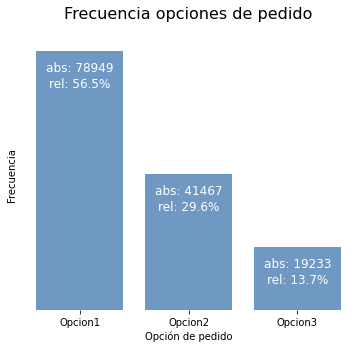

In [10]:
#Se va a realizar una grafica de barras de los pedidos por opcion de pedidos.
#Obteniendo series x, y como arreglos
xvalues = train['numericDeliveryOption'].value_counts().index
yvalues = train['numericDeliveryOption'].value_counts().values
yrel = yvalues/sum(yvalues)

#Tamaño de la figura
plt.figure(figsize=(6,5))

#dibujando la grafica de barras
bars = plt.bar(["Opcion"+str(i) for i in xvalues], yvalues, color='#326da8', alpha = 0.7)

#Nombres de los ejes
ax = plt.gca()
ax.set_xlabel("Opción de pedido")
ax.set_ylabel("Frecuencia")

#Se remueve el marco de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Remover los ticks
plt.tick_params(left=False, labelleft=False)
plt.title("Frecuencia opciones de pedido", fontsize=16, pad=20)

#Agregar los porcentajes correspondientes a cada barra
for i, bar in enumerate(bars):
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 6000, 'abs: ' + str(int(bar.get_height())), ha='center', color='w', fontsize=12)
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 11000, 'rel: ' + str(int(yrel[i]*1000)/10)+'%', ha='center', color='w', fontsize=12)


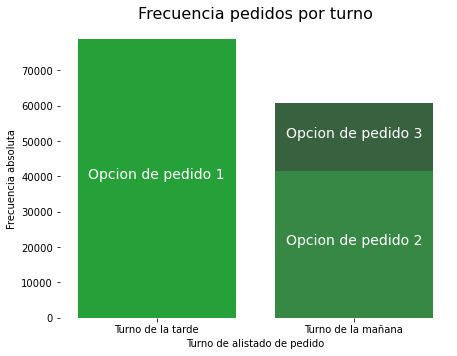

In [11]:
#Se va a realizar una grafica de barras de los pedidos segun el turno en el que deben ser entregados
#Aqui se tiene encuenta el planteamiento del problema:
# - Para los pedidos de la opción 1 el problema establece que deben ser alistados en el turno de la tarde
# - Los pedidos de la opción 2 deben ser alistados en el turno de la mañana. Esto es debido a que deben ser alistados
#   el mismo día de su entrega y estos se deben entregar entre 12:30PM y 2:30PM, lo que implica que deben salir en el
#   camión de las 12:00PM
# - Para los pedidos de la opción 3 el problema establece que deben ser alistados el mismo día por la mañana (a pesar de 
#   que se entreguen entre 6:30PM y 8:30PM)
#Obteniendo series x, y como arreglos
xvalues = ['Turno de la tarde', 'Turno de la mañana']
yvalues = train['numericDeliveryOption'].value_counts().values
y1 = yvalues[:2]
y2 = [0, yvalues[2]]

#Tamaño de la figura
fig = plt.figure(figsize=(7,5))

#dibujando la grafica de barras
bars1 = plt.bar(xvalues, y1, color=['#009116','#147323'], alpha = 0.85)
bars2 = plt.bar(xvalues, y2, color='#15451d', alpha = 0.85, bottom = y1)

#Nombres de los ejes
ax = plt.gca()
ax.set_xlabel("Turno de alistado de pedido")
ax.set_ylabel("Frecuencia absoluta")

#Se remueve el marco de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Agregar el titulo
plt.title("Frecuencia pedidos por turno", fontsize=16, pad=20)
#Ajustar el tituto
fig.subplots_adjust(top = 0.9)

#Agregar label a cada una de las barras
arr_bar=[bar for bar in bars1]
arr_bar.extend([bar for bar in bars2[1:]])
bar = arr_bar[0]
plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 'Opcion de pedido 1', ha='center', color='w', fontsize=14)
bar = arr_bar[1]
plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 'Opcion de pedido 2', ha='center', color='w', fontsize=14)
bar2 = arr_bar[2]
_ = plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar2.get_height()/2, 'Opcion de pedido 3', ha='center', color='w', fontsize=14)



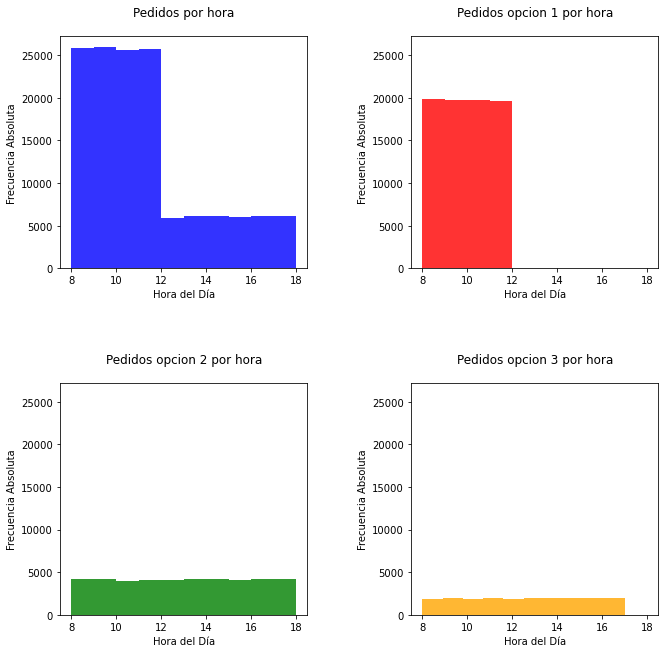

In [12]:
#Se calcula la hora del día en el cual se ordeno cada pedido. Se van a hacer varios histogramas de la distribución de
#horas de pedidos de acuerdo al tipo de pedido. En particular, se quiere confirmar que los horarios de pedidos enten
#cumpliendo con las condiciones establecidas en el problema. NOTA: Tambien se pudo observar la hora en la que se hacen los
#pedidos aparenta seguir un distribucion uniforme cuando los dividimos por opcion de pedido.
train['hour'] = train['RequestTime'].apply(lambda x: x.hour)

#Definiendo los subplots
fig, ((ax1,ax2),(ax3,ax4))=plt.subplots(2,2, sharey=True, sharex = True)
ax1.tick_params(labelbottom=True,labelleft=True)
ax1.set_xlabel('Hora del Día')
ax1.set_ylabel('Frecuencia Absoluta')
ax2.tick_params(labelbottom=True,labelleft=True)
ax2.set_xlabel('Hora del Día')
ax2.set_ylabel('Frecuencia Absoluta')
ax3.tick_params(labelbottom=True,labelleft=True)
ax3.set_xlabel('Hora del Día')
ax3.set_ylabel('Frecuencia Absoluta')
ax4.tick_params(labelbottom=True,labelleft=True)
ax4.set_xlabel('Hora del Día')
ax4.set_ylabel('Frecuencia Absoluta')

fig.tight_layout()
#Tamaño de la imagen
fig.set_size_inches((10,10))

#Dibujando los histogramas
ax1.hist(train['hour'], bins=10, color = 'b', alpha = 0.8)
ax1.set_title('Pedidos por hora', pad=20)
ax2.hist(train[train['numericDeliveryOption']==1]['hour'], bins=4, color = 'r', alpha = 0.8)
ax2.set_title('Pedidos opcion 1 por hora', pad=20)
ax3.hist(train[train['numericDeliveryOption']==2]['hour'], bins=10, color = 'g', alpha = 0.8)
ax3.set_title('Pedidos opcion 2 por hora', pad=20)
ax4.hist(train[train['numericDeliveryOption']==3]['hour'], bins=10, color = 'orange', alpha = 0.8)
_=ax4.set_title('Pedidos opcion 3 por hora', pad=20)



In [13]:
#Calculando la fecha exacta en la cual se debe alistar el producto. Este es un rango de tiempo de alguno de los
#dos turnos que trabajan los pickers. Se le va a poner la mitad de este intervalo. La fecha exacata es calculada a
#partir de la fecha de pedido y de la opcion de pedido
def get_shift_date(date, option):
    if option == 1:
        return pd.Timestamp(year=date.year,month=date.month,day=date.day,hour=15)
    if option == 2:
        return pd.Timestamp(year=date.year,month=date.month,day=date.day,hour=10) + pd.Timedelta(days=1)
    if option == 3:
        return pd.Timestamp(year=date.year,month=date.month,day=date.day,hour=10) + pd.Timedelta(days=1)
    
def get_shift(date):
    if date.hour == 10:
        return 1
    if date.hour == 15:
        return 2
    return -1
train['enlisted_date'] = train[['numericDeliveryOption', 'RequestTime']].apply(lambda x: get_shift_date(x['RequestTime'], x['numericDeliveryOption']), axis = 1)
train['dayofweek'] = train['enlisted_date'].apply(lambda x: x.dayofweek)
train['shift'] = train['enlisted_date'].apply(lambda x: get_shift(x))

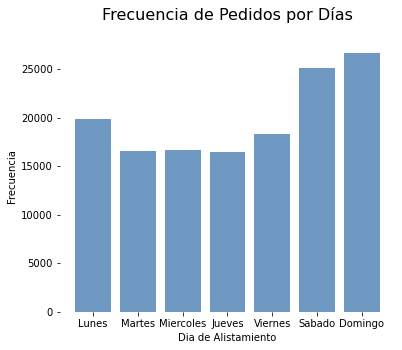

In [14]:
#Se va a realizar una grafica de barras de los pedidos por el dia de la semana en el cual se deben alistar.
#NOTA: Se puede observa que los pedidos no se distribuyen uniformemente en el día de la semana

#Obteniendo series x, y como arreglos
xvalues = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado', 'Domingo']
yvalues = train[['dayofweek', 'OrderId']].groupby('dayofweek').count()['OrderId'].values
yrel = yvalues/sum(yvalues)

#Tamaño de la figura
plt.figure(figsize=(6,5))

#dibujando la grafica de barras
bars = plt.bar(xvalues, yvalues, color='#326da8', alpha = 0.7)

#Nombres de los ejes
ax = plt.gca()
ax.set_xlabel("Dia de Alistamiento")
ax.set_ylabel("Frecuencia")

#Se remueve el marco de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Remover los ticks
_ = plt.title("Frecuencia de Pedidos por Días", fontsize=16, pad=20)



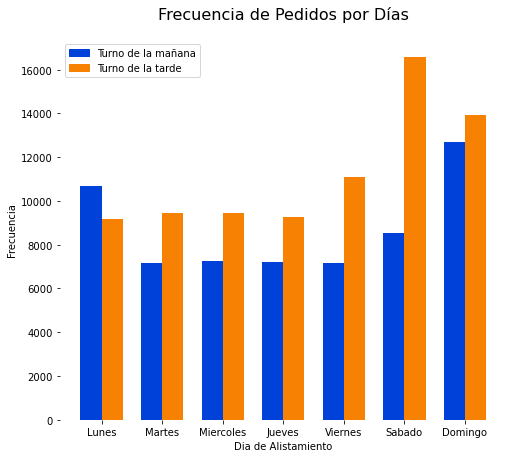

In [15]:
#Se va a realizar una la gráfica anterior pero esta vez dividida por el turno en el cual se deben alistar los pedidos.
#NOTA: Se observa que incluso en el mismo día de la semana hay desbalance en el turno.
#Obteniendo series x, y como arreglos
aux = train[['dayofweek', 'shift', 'OrderId']].groupby(['shift', 'dayofweek']).count()
xvalues = ['','Lunes','Martes','Miercoles','Jueves','Viernes','Sabado', 'Domingo']
yvalues1 = aux.loc[1]['OrderId'].values
yvalues2 = aux.loc[2]['OrderId'].values
xaux1 = [i-0.175 for i in range(7)]
xaux2 = [i+0.175 for i in range(7)]
#Tamaño de la figura
plt.figure(figsize=(8,7))

#dibujando la grafica de barras
bars = plt.bar(xaux1, yvalues1, color='#0041d9', width = 0.35)
bars = plt.bar(xaux2, yvalues2, color='#f78102', width = 0.35)

#Nombres de los ejes
ax = plt.gca()
ax.set_xlabel("Dia de Alistamiento")
ax.set_ylabel("Frecuencia")

#Se remueve el marco de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#se ponen las nuevas marcas de eje
ax.set_xticklabels(xvalues)


#Agregar legenda
colors = {'Turno de la mañana':'#0041d9', 'Turno de la tarde':'#f78102'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
#Agregando título
_ = plt.title("Frecuencia de Pedidos por Días", fontsize=16, pad=20)

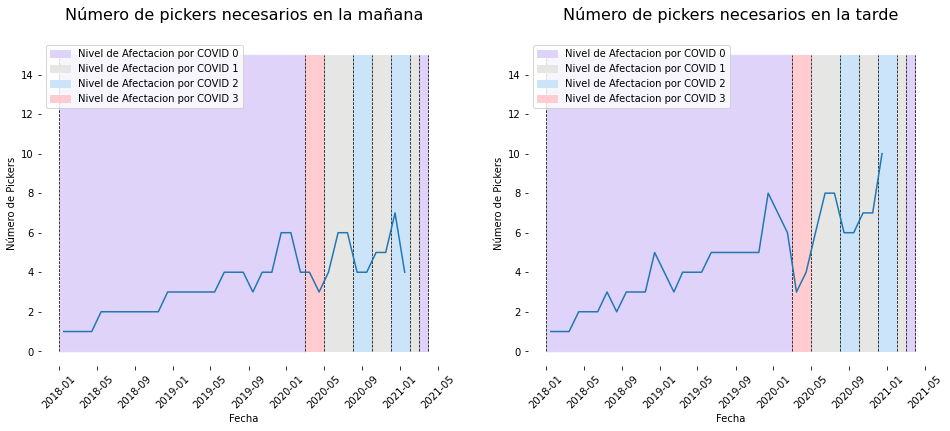

In [16]:
#Calculando y graficando el número de trabajadores mínimo que se necesita los periodos del conjunto de entrenamiento
#Configuración general del gráfico
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

#Aquí se calcula el número de pickers necesarios con base en el núnmero de pedidos que se hicieron en el perido del
#conjunto de entrenamiento (enero de 2018 a diciembre de 2020). En primer lugar se cuentan los pedidos de cada día de
#cada turno. Esto se hace con una agrupación de la tabla
train['month'] = train['enlisted_date'].apply(lambda x: x.month)
train['year'] = train['enlisted_date'].apply(lambda x: x.year)
aux = train[['shift','enlisted_date','month','year', 'OrderId']].groupby(['shift','enlisted_date']).agg({
    'OrderId':'count',
    'month':'max',
    'year':'max'})

#Despues se realiza otra agrupación por mes, donde se obtiene el máximo de cada mes de los turnos de la mañana y de la tarde.
#En los supuestos del problema se indica que se contrata una cantidad fija por mes y no se puede incumplir con el alista-
#miento de ningún pedido. Por lo tanto, se obtiene el maximo de pedidos de cada mes por turno y según este valor se va a
#calcula el numero de pickers
aux1 = aux.loc[1].groupby(['year','month']).max()
aux2 = aux.loc[2].groupby(['year','month']).max()

#Teniendo en cuenta que cada picker alista 5 envios por hora y trabaja 6 horas. Esto se traduce a 30 pedidos alistados por
#turno. Con esto se calculan los pickers necesarios para cada mes. En este caso para el turno de la mañana
yvalues = aux1['OrderId'].values
yvalues = [np.ceil(y/30) for y in yvalues]
xvalues = aux1['OrderId'].index
xvalues = [pd.Timestamp(d[0], d[1], 15) for d in xvalues]
plt.plot(xvalues, yvalues)

#calculando las fechas donde hay cambios en el nivel de afectacion
fechas_cambio = [pd.Timestamp(2018,1,1)]
nivel_cambio = [0]
for i in range(1, len(level)):
    if level.iloc[i]['Level of affectedness'] != level.iloc[i-1]['Level of affectedness']:
        fechas_cambio.append(level.iloc[i]['Date'])
        nivel_cambio.append(level.iloc[i]['Level of affectedness'])

fechas_cambio.append(pd.Timestamp(2021,4,1))
nivel_cambio.append(0)      

#Agregando las divisiones en la imagen
plt.vlines(fechas_cambio, 0,15, linewidth = 0.75, color ='black', linestyles = 'dashed')

ax = plt.gca()

#Coloreando las secciones según su nivel de severidad
color_d = {0:'#e0d3f9', 1:'#e6e6e4', 2:'#cce4f9', 3:'#ffccd1'}
for i in range(len(fechas_cambio)-1):
    plt.fill_between(pd.date_range(fechas_cambio[i], fechas_cambio[i+1]), 15, 0, color = color_d[nivel_cambio[i]])
    
#Añadiendo leyenda
labels = list(color_d.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_d[label]) for label in labels]
plt.legend(handles, ['Nivel de Afectacion por COVID '+str(l) for l in labels], loc='upper left')

#Se remueve el marco de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)



#Nombres de los ejes
ax.set_xlabel("Fecha")
plt.xticks(rotation =45)
ax.set_ylabel("Número de Pickers")

_=plt.title("Número de pickers necesarios en la mañana", fontsize=16, pad=20)


############################################################


plt.subplot(1,2,2)

#Teniendo en cuenta que cada picker alista 5 envios por hora y trabaja 6 horas. Esto se traduce a 30 pedidos alistados por
#turno. Con esto se calculan los pickers necesarios para cada mes. En este caso para el turno de la mañana
yvalues = aux2['OrderId'].values
yvalues = [np.ceil(y/30) for y in yvalues]
xvalues = aux2['OrderId'].index
xvalues = [pd.Timestamp(d[0], d[1], 15) for d in xvalues]
plt.plot(xvalues, yvalues)

#Agregando las divisiones en la imagen
plt.vlines(fechas_cambio, 0,15, linewidth = 0.75, color ='black', linestyles = 'dashed')

ax = plt.gca()

#Coloreando las secciones según su nivel de severidad
color_d = {0:'#e0d3f9', 1:'#e6e6e4', 2:'#cce4f9', 3:'#ffccd1'}
for i in range(len(fechas_cambio)-1):
    plt.fill_between(pd.date_range(fechas_cambio[i], fechas_cambio[i+1]), 15,0, color = color_d[nivel_cambio[i]])
    
#Añadiendo leyenda
labels = list(color_d.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_d[label]) for label in labels]
plt.legend(handles, ['Nivel de Afectacion por COVID '+str(l) for l in labels], loc='upper left')

#Se remueve el marco de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)



#Nombres de los ejes
ax.set_xlabel("Fecha")
plt.xticks(rotation = 45)
ax.set_ylabel("Número de Pickers")

_=plt.title("Número de pickers necesarios en la tarde", fontsize=16, pad=20)

In [17]:
#Pickers necesarios para el turno de la mañana
aux1

OrderId
year month         
2018 1           25
     2           21
     3           23
     4           26
     5           32
     6           46
     7           56
     8           41
     9           45
     10          56
     11          53
     12          90
2019 1           87
     2           69
     3           65
     4           74
     5           76
     6          110
     7          101
     8           93
     9           87
     10          91
     11          98
     12         169
2020 1          151
     2          104
     3          104
     4           73
     5          111
     6          164
     7          158
     8          110
     9          109
     10         136
     11         138
     12         197
2021 1           92

In [18]:
#Pickers necesarios para el turno de la tarde
aux2

OrderId
year month         
2018 1           21
     2           22
     3           28
     4           32
     5           37
     6           53
     7           67
     8           54
     9           62
     10          68
     11          72
     12         126
2019 1          103
     2           88
     3           95
     4           98
     5          107
     6          145
     7          145
     8          124
     9          125
     10         134
     11         134
     12         220
2020 1          193
     2          151
     3           89
     4           99
     5          156
     6          231
     7          239
     8          152
     9          158
     10         185
     11         191
     12         275

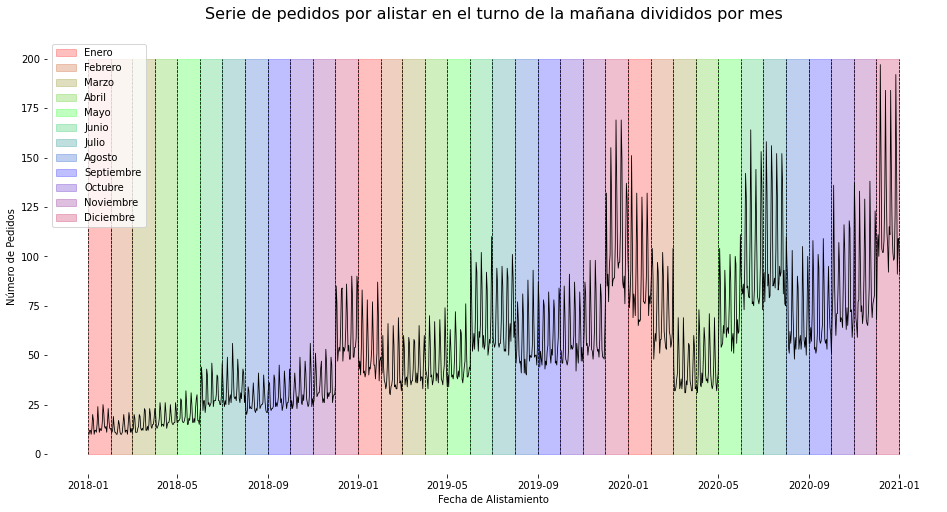

In [19]:
#Gráfica de linea para mostrar la tendencia de los pedidos que se deben alistar en el turno de la mañana
#Se van a mostrar divisiones en la gráfica por mes
aux = train[['OrderId', 'enlisted_date']][train['shift']==1].groupby('enlisted_date').count()
yvalues = aux['OrderId'].values
xvalues = aux['OrderId'].index

plt.figure(figsize=(16,8))

plt.plot(xvalues, yvalues, linewidth=0.8, color='black')

#calculando las fechas donde hay cambios en el nivel de afectacion
fechas_cambio = [pd.Timestamp(2018,1,1)]
for i in range(1, len(level)):
    if level.iloc[i]['Date'] <= pd.Timestamp(2021,1,1):
        fechas_cambio.append(level.iloc[i]['Date'])

#Agregando las divisiones en la imagen
plt.vlines(fechas_cambio, 0,200, linewidth = 0.75, color ='black', linestyles = 'dashed')




#Coloreando las secciones según el mes
color_d = {1:'#FF0000', 2:'#C04000', 3:'#808000', 4:'#40C000',
            5:'#00FF00', 6:'#00C040', 7:'#008080',8:'#0040C0',
           9:'#0000FF', 10:'#4000C0', 11:'#800080', 12:'#C00040'}

meses = {
    1:'Enero',
    2:'Febrero',
    3:'Marzo',
    4:'Abril',
    5:'Mayo',
    6:'Junio',
    7:'Julio',
    8:'Agosto',
    9:'Septiembre',
    10:'Octubre',
    11:'Noviembre',
    12:'Diciembre'
}
for i in range(len(fechas_cambio)-1):
    plt.fill_between(pd.date_range(fechas_cambio[i], fechas_cambio[i+1]), 200, 0, color = color_d[fechas_cambio[i].month], alpha = 0.25)
    
#Añadiendo leyenda
labels = list(color_d.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_d[label], alpha=0.25) for label in labels]
plt.legend(handles, [meses[l] for l in labels], loc='upper left')
                    
#Se remueve el marco de la gráfica
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Nombres de los ejes
ax.set_xlabel("Fecha de Alistamiento")
ax.set_ylabel("Número de Pedidos")

_=plt.title("Serie de pedidos por alistar en el turno de la mañana divididos por mes", fontsize=16, pad=20)

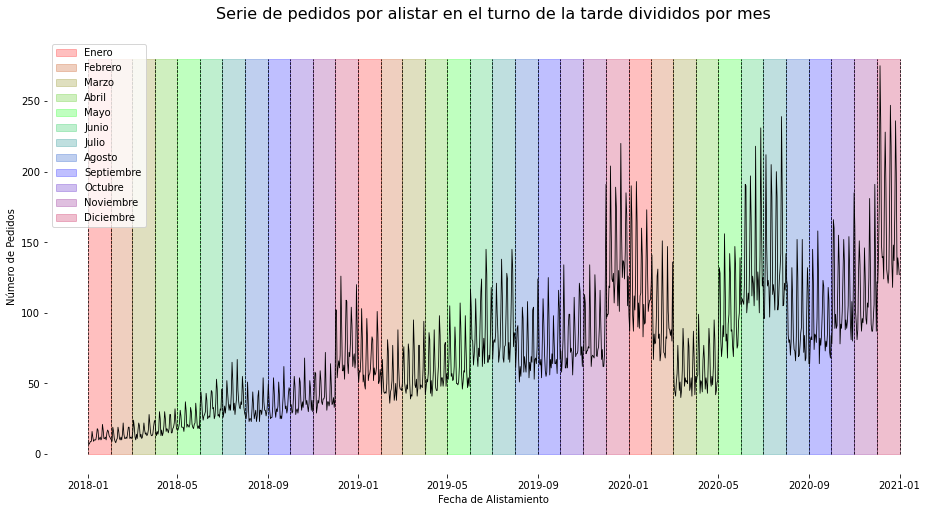

In [20]:
#Gráfica de linea para mostrar la tendencia de los pedidos que se deben alistar en el turno de la mañana
#Se van a mostrar divisiones en la gráfica por mes
aux = train[['OrderId', 'enlisted_date']][train['shift']==2].groupby('enlisted_date').count()
yvalues = aux['OrderId'].values
xvalues = aux['OrderId'].index

plt.figure(figsize=(16,8))

plt.plot(xvalues, yvalues, linewidth=0.8, color='black')

#calculando las fechas donde hay cambios en el nivel de afectacion
fechas_cambio = [pd.Timestamp(2018,1,1)]
for i in range(1, len(level)):
    if level.iloc[i]['Date'] <= pd.Timestamp(2021,1,1):
        fechas_cambio.append(level.iloc[i]['Date'])

#Agregando las divisiones en la imagen
plt.vlines(fechas_cambio, 0,280, linewidth = 0.75, color ='black', linestyles = 'dashed')




#Coloreando las secciones según su nivel de severidad
color_d = {1:'#FF0000', 2:'#C04000', 3:'#808000', 4:'#40C000',
            5:'#00FF00', 6:'#00C040', 7:'#008080',8:'#0040C0',
           9:'#0000FF', 10:'#4000C0', 11:'#800080', 12:'#C00040'}
for i in range(len(fechas_cambio)-1):
    plt.fill_between(pd.date_range(fechas_cambio[i], fechas_cambio[i+1]), 280, 0, color = color_d[fechas_cambio[i].month], alpha = 0.25)
    
#Añadiendo leyenda
labels = list(color_d.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_d[label], alpha=0.25) for label in labels]
plt.legend(handles, [meses[l] for l in labels], loc='upper left')

#Se remueve el marco de la gráfica
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Nombres de los ejes
ax.set_xlabel("Fecha de Alistamiento")
ax.set_ylabel("Número de Pedidos")

_=plt.title("Serie de pedidos por alistar en el turno de la tarde divididos por mes", fontsize=16, pad=20)

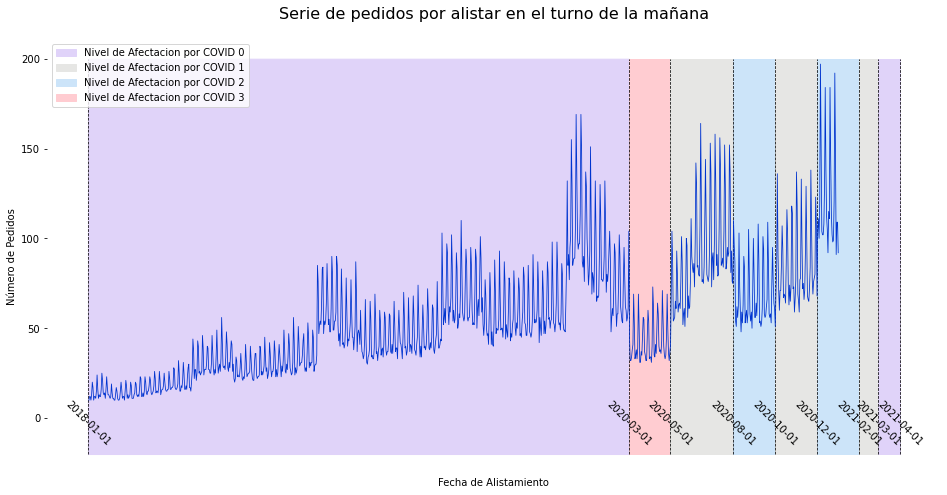

In [21]:
#Gráfica de linea para mostrar la tendencia de los pedidos que se deben alistar en el turno de la mañana
#Se van a mostrar divisiones en la grafica mostrando el nivel de afectacion.
aux = train[['OrderId', 'enlisted_date']][train['shift']==1].groupby('enlisted_date').count()
yvalues = aux['OrderId'].values
xvalues = aux['OrderId'].index

plt.figure(figsize=(16,8))

plt.plot(xvalues, yvalues, linewidth=0.8, color='#0034cf')

#calculando las fechas donde hay cambios en el nivel de afectacion
fechas_cambio = [pd.Timestamp(2018,1,1)]
nivel_cambio = [0]
for i in range(1, len(level)):
    if level.iloc[i]['Level of affectedness'] != level.iloc[i-1]['Level of affectedness']:
        fechas_cambio.append(level.iloc[i]['Date'])
        nivel_cambio.append(level.iloc[i]['Level of affectedness'])

fechas_cambio.append(pd.Timestamp(2021,4,1))
nivel_cambio.append(0)      

#Agregando las divisiones en la imagen
plt.vlines(fechas_cambio, -20,200, linewidth = 0.75, color ='black', linestyles = 'dashed')

#Agregando el lablels de cada una de las divisiones de la imagen
ax = plt.gca()
for i in range(len(fechas_cambio)):
    ax.text(fechas_cambio[i], -15, fechas_cambio[i].strftime("%Y-%m-%d"), ha='center', rotation =-45.)

#Coloreando las secciones según su nivel de severidad
color_d = {0:'#e0d3f9', 1:'#e6e6e4', 2:'#cce4f9', 3:'#ffccd1'}
for i in range(len(fechas_cambio)-1):
    plt.fill_between(pd.date_range(fechas_cambio[i], fechas_cambio[i+1]), 200,-20, color = color_d[nivel_cambio[i]])
    
#Añadiendo leyenda
labels = list(color_d.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_d[label]) for label in labels]
plt.legend(handles, ['Nivel de Afectacion por COVID '+str(l) for l in labels], loc='upper left')

#Se remueve el marco de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Remover los ticks
plt.tick_params(bottom=False,top=False, labelbottom=False)

#Nombres de los ejes
ax.set_xlabel("Fecha de Alistamiento")
ax.set_ylabel("Número de Pedidos")

_=plt.title("Serie de pedidos por alistar en el turno de la mañana", fontsize=16, pad=20)

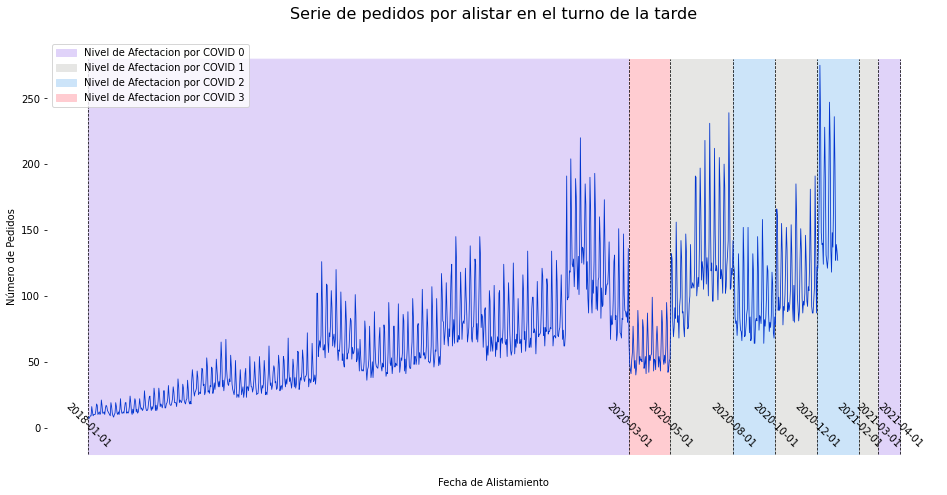

In [22]:
#Gráfica de linea para mostrar la tendencia de los pedidos que se deben alistar en el turno de la tarde
#Se van a mostrar divisiones en la grafica mostrando el nivel de afectacion.
aux = train[['OrderId', 'enlisted_date']][train['shift']==2].groupby('enlisted_date').count()
yvalues = aux['OrderId'].values
xvalues = aux['OrderId'].index

plt.figure(figsize=(16,8))

plt.plot(xvalues, yvalues, linewidth=0.8, color='#0034cf')

#calculando las fechas donde hay cambios en el nivel de afectacion
fechas_cambio = [pd.Timestamp(2018,1,1)]
nivel_cambio = [0]
for i in range(1, len(level)):
    if level.iloc[i]['Level of affectedness'] != level.iloc[i-1]['Level of affectedness']:
        fechas_cambio.append(level.iloc[i]['Date'])
        nivel_cambio.append(level.iloc[i]['Level of affectedness'])

fechas_cambio.append(pd.Timestamp(2021,4,1))
nivel_cambio.append(0)      

#Agregando las divisiones en la imagen
plt.vlines(fechas_cambio, -20,280, linewidth = 0.75, color ='black', linestyles = 'dashed')

#Agregando el lablels de cada una de las divisiones de la imagen
ax = plt.gca()
for i in range(len(fechas_cambio)):
    ax.text(fechas_cambio[i], -15, fechas_cambio[i].strftime("%Y-%m-%d"), ha='center', rotation =-45.)

#Coloreando las secciones según su nivel de severidad
color_d = {0:'#e0d3f9', 1:'#e6e6e4', 2:'#cce4f9', 3:'#ffccd1'}
for i in range(len(fechas_cambio)-1):
    plt.fill_between(pd.date_range(fechas_cambio[i], fechas_cambio[i+1]), 280,-20, color = color_d[nivel_cambio[i]])
    
#Añadiendo leyenda
labels = list(color_d.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_d[label]) for label in labels]
plt.legend(handles, ['Nivel de Afectacion por COVID '+str(l) for l in labels], loc='upper left')

#Se remueve el marco de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Remover los ticks
plt.tick_params(bottom=False,top=False, labelbottom=False)

#Nombres de los ejes
ax.set_xlabel("Fecha de Alistamiento")
ax.set_ylabel("Número de Pedidos")

#Titulo del gráfico
_=plt.title("Serie de pedidos por alistar en el turno de la tarde", fontsize=16, pad=20)

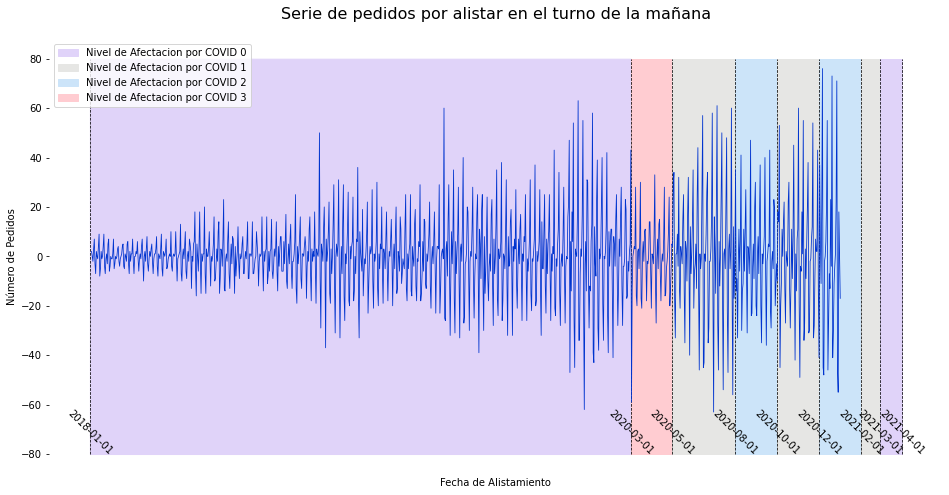

In [23]:
#Gráfica de linea para mostrar la tendencia de los pedidos que se deben alistar en el turno de la mañana
#Se van a mostrar divisiones en la grafica mostrando el nivel de afectacion.
aux = train[['OrderId', 'enlisted_date']][train['shift']==1].groupby('enlisted_date').count().diff()
yvalues = aux['OrderId'].values
xvalues = aux['OrderId'].index

plt.figure(figsize=(16,8))

plt.plot(xvalues, yvalues, linewidth=0.8, color='#0034cf')

#calculando las fechas donde hay cambios en el nivel de afectacion
fechas_cambio = [pd.Timestamp(2018,1,1)]
nivel_cambio = [0]
for i in range(1, len(level)):
    if level.iloc[i]['Level of affectedness'] != level.iloc[i-1]['Level of affectedness']:
        fechas_cambio.append(level.iloc[i]['Date'])
        nivel_cambio.append(level.iloc[i]['Level of affectedness'])

fechas_cambio.append(pd.Timestamp(2021,4,1))
nivel_cambio.append(0)      

#Agregando las divisiones en la imagen
plt.vlines(fechas_cambio, -80,80, linewidth = 0.75, color ='black', linestyles = 'dashed')

#Agregando el lablels de cada una de las divisiones de la imagen
ax = plt.gca()
for i in range(len(fechas_cambio)):
    ax.text(fechas_cambio[i], -80, fechas_cambio[i].strftime("%Y-%m-%d"), ha='center', rotation =-45.)

#Coloreando las secciones según su nivel de severidad
color_d = {0:'#e0d3f9', 1:'#e6e6e4', 2:'#cce4f9', 3:'#ffccd1'}
for i in range(len(fechas_cambio)-1):
    plt.fill_between(pd.date_range(fechas_cambio[i], fechas_cambio[i+1]), 80,-80, color = color_d[nivel_cambio[i]])
    
#Añadiendo leyenda
labels = list(color_d.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_d[label]) for label in labels]
plt.legend(handles, ['Nivel de Afectacion por COVID '+str(l) for l in labels], loc='upper left')

#Se remueve el marco de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Remover los ticks
plt.tick_params(bottom=False,top=False, labelbottom=False)

#Nombres de los ejes
ax.set_xlabel("Fecha de Alistamiento")
ax.set_ylabel("Número de Pedidos")

_=plt.title("Serie de pedidos por alistar en el turno de la mañana", fontsize=16, pad=20)

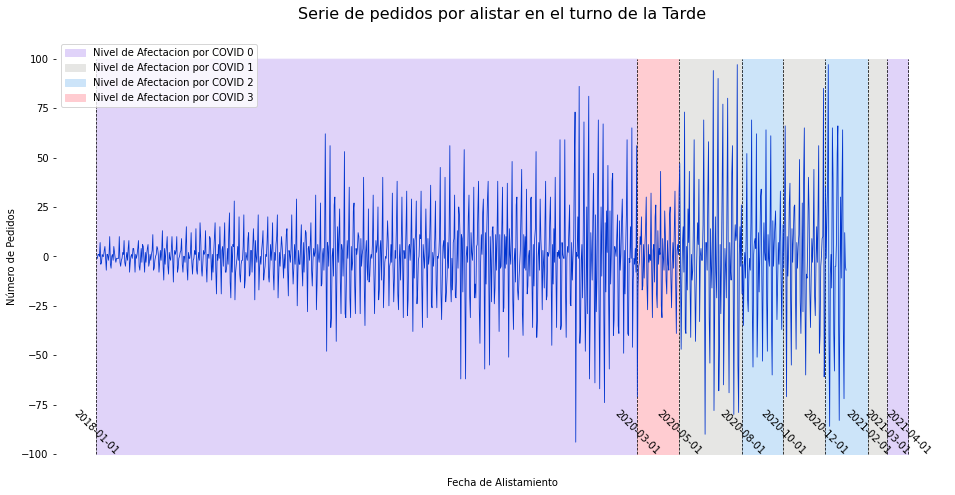

In [24]:
#Gráfica de linea para mostrar la tendencia de los pedidos que se deben alistar en el turno de la mañana
#Se van a mostrar divisiones en la grafica mostrando el nivel de afectacion.
aux = train[['OrderId', 'enlisted_date']][train['shift']==2].groupby('enlisted_date').count().diff()
yvalues = aux['OrderId'].values
xvalues = aux['OrderId'].index

plt.figure(figsize=(16,8))

plt.plot(xvalues, yvalues, linewidth=0.8, color='#0034cf')

#calculando las fechas donde hay cambios en el nivel de afectacion
fechas_cambio = [pd.Timestamp(2018,1,1)]
nivel_cambio = [0]
for i in range(1, len(level)):
    if level.iloc[i]['Level of affectedness'] != level.iloc[i-1]['Level of affectedness']:
        fechas_cambio.append(level.iloc[i]['Date'])
        nivel_cambio.append(level.iloc[i]['Level of affectedness'])

fechas_cambio.append(pd.Timestamp(2021,4,1))
nivel_cambio.append(0)      

#Agregando las divisiones en la imagen
plt.vlines(fechas_cambio, -100,100, linewidth = 0.75, color ='black', linestyles = 'dashed')

#Agregando el lablels de cada una de las divisiones de la imagen
ax = plt.gca()
for i in range(len(fechas_cambio)):
    ax.text(fechas_cambio[i], -100, fechas_cambio[i].strftime("%Y-%m-%d"), ha='center', rotation =-45.)

#Coloreando las secciones según su nivel de severidad
color_d = {0:'#e0d3f9', 1:'#e6e6e4', 2:'#cce4f9', 3:'#ffccd1'}
for i in range(len(fechas_cambio)-1):
    plt.fill_between(pd.date_range(fechas_cambio[i], fechas_cambio[i+1]), 100,-100, color = color_d[nivel_cambio[i]])
    
#Añadiendo leyenda
labels = list(color_d.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_d[label]) for label in labels]
plt.legend(handles, ['Nivel de Afectacion por COVID '+str(l) for l in labels], loc='upper left')

#Se remueve el marco de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Remover los ticks
plt.tick_params(bottom=False,top=False, labelbottom=False)

#Nombres de los ejes
ax.set_xlabel("Fecha de Alistamiento")
ax.set_ylabel("Número de Pedidos")

_=plt.title("Serie de pedidos por alistar en el turno de la Tarde", fontsize=16, pad=20)

In [25]:
#Se implementa una funcion que calcula un augmented dickey fuller test para ver si una serie es estacionaria
def pruebaEstacionaridad(serieTiempo):
    print('Resultados del test Dickey - Fuller:')
    dftest = adfuller(serieTiempo, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Estadístico', 'ValorP', 'Retardos Usados', 'Observaciones Usadas'])
    for key, value in dftest[4].items():
        dfoutput['Valores Críticos (%s)'%key] = value
    print(dfoutput)

In [26]:
#augmented dickey fuller test para la serie de pedidos alistados en el turno de la mañana
aux = train[['OrderId', 'enlisted_date']][train['shift']==1].groupby('enlisted_date').count()
pruebaEstacionaridad(aux)

Resultados del test Dickey - Fuller:
Test Estadístico            -1.410806
ValorP                       0.577085
Retardos Usados             22.000000
Observaciones Usadas      1073.000000
Valores Críticos (1%)       -3.436459
Valores Críticos (5%)       -2.864237
Valores Críticos (10%)      -2.568206
dtype: float64


In [27]:
#augmented dickey fuller test para la serie de la primera diferencia discreta de pedidos alistados en el turno de la mañana
pruebaEstacionaridad(aux.diff().iloc[1:])

Resultados del test Dickey - Fuller:
Test Estadístico         -7.512945e+00
ValorP                    3.971186e-11
Retardos Usados           2.200000e+01
Observaciones Usadas      1.072000e+03
Valores Críticos (1%)    -3.436465e+00
Valores Críticos (5%)    -2.864240e+00
Valores Críticos (10%)   -2.568208e+00
dtype: float64


In [28]:
#augmented dickey fuller test para la serie de pedidos alistados en el turno de la tarde
aux = train[['OrderId', 'enlisted_date']][train['shift']==2].groupby('enlisted_date').count()
pruebaEstacionaridad(aux)

Resultados del test Dickey - Fuller:
Test Estadístico            -1.317400
ValorP                       0.621175
Retardos Usados             22.000000
Observaciones Usadas      1073.000000
Valores Críticos (1%)       -3.436459
Valores Críticos (5%)       -2.864237
Valores Críticos (10%)      -2.568206
dtype: float64


In [29]:
#augmented dickey fuller test para la serie de la primera diferencia discreta de pedidos alistados en el turno de la tarde
pruebaEstacionaridad(aux.diff().iloc[1:])

Resultados del test Dickey - Fuller:
Test Estadístico         -7.080963e+00
ValorP                    4.667771e-10
Retardos Usados           2.100000e+01
Observaciones Usadas      1.073000e+03
Valores Críticos (1%)    -3.436459e+00
Valores Críticos (5%)    -2.864237e+00
Valores Críticos (10%)   -2.568206e+00
dtype: float64


In [30]:
funcionAutocorrelacion = acf(train[['OrderId', 'enlisted_date']][train['shift']==1].groupby('enlisted_date').count(), nlags = 20)
funcionAutocorrelacionParcial = pacf(train[['OrderId', 'enlisted_date']][train['shift']==1].groupby('enlisted_date').count(), nlags = 20, method = 'ols')

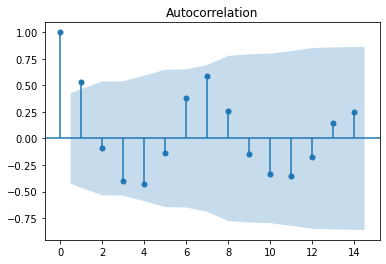

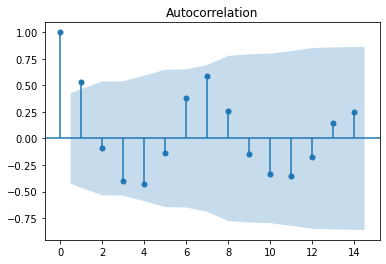

In [31]:
plot_acf(funcionAutocorrelacion)

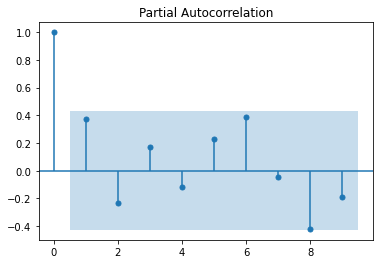

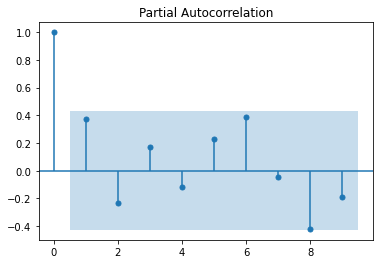

In [32]:
plot_pacf(funcionAutocorrelacionParcial, lags = 9)

### Data Procesing

In [33]:
#Se va a realizar un pipeline sencillo para agrupar los datos por días y por turnos. Donde se obtiene el histórico del
#número de pedidos por día por turno.
train = data[data['RequestTime'] < pd.to_datetime('2021-01-01 00:00:00')]
test = data[data['RequestTime'] >= pd.to_datetime('2021-01-01 00:00:00')]

In [34]:
class get_shift_data(BaseEstimator, TransformerMixin):
    #Clase para imputar los datos de la fecha en la cual se debe alistar y el turno al que pertenece (mañana o tarde)
    def get_shift_date(self, date, option):
        if option == 1:
            return pd.Timestamp(year=date.year,month=date.month,day=date.day,hour=15)
        if option == 2:
            return pd.Timestamp(year=date.year,month=date.month,day=date.day,hour=10) + pd.Timedelta(days=1)
        if option == 3:
            return pd.Timestamp(year=date.year,month=date.month,day=date.day,hour=10) + pd.Timedelta(days=1)
    
    def get_shift(self, date):
        if date.hour == 10:
            return 1
        if date.hour == 15:
            return 2
        return -1
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X['enlisted_date'] = X[['numericDeliveryOption', 'RequestTime']].apply(lambda x: self.get_shift_date(x['RequestTime'], x['numericDeliveryOption']), axis = 1)
        X['shift'] = X['enlisted_date'].apply(lambda x: self.get_shift(x))
        return X
    
class group_select_data(BaseEstimator, TransformerMixin):
    #Clase para agrupar los datos según su fecha en que se deben alistar
    #Tambien se selecciona el turno deseado (mañana o tarde)
    #Tambien se tiene la opcion de devolver las diferencias discretas del orden que se desee
    def __init__(self, shift = 1, diff=0):
        self.shift = shift
        self.diff = diff
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        X = X[['OrderId','enlisted_date', 'shift']].groupby(['shift', 'enlisted_date']).count()
        X = X.loc[self.shift]
        X['OrderId'] = X['OrderId'].astype(np.float64)
        for i in range(self.diff):
            X = X.diff()
        return X.dropna()
    
class get_affectedness(BaseEstimator, TransformerMixin):
    def get_affectedness(self, date):
        return level[(level['Year']==date.year) & (level['Month'] == date.month)]['Level of affectedness'].iloc[0]
    def __init__(self):
        self.ini = pd.Timestamp(2018,1,1)
        self.fin = pd.Timestamp(2021,3,31)
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X = None, y = None):
        dates = pd.date_range(self.ini, self.fin)
        arr = [self.get_affectedness(date) for date in dates]
        X = pd.Series(arr, dates)
        return X
    
class group_affecteness(BaseEstimator, TransformerMixin):
    def __init__(self, n_steps = 10):
        self.n_steps = n_steps
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        ans = np.zeros((len(X), self.n_steps))
        for i in range(self.n_steps):
            ans[:,i] = np.concatenate([np.zeros(i),X.values[:len(X)-i]])
        return pd.DataFrame(ans, index = X.index)
    

In [35]:
p_turno_1 = Pipeline([
    ('g_s_d', get_shift_data()),
    ('gr_s_d', group_select_data())
])

p_turno_2 = Pipeline([
    ('g_s_d', get_shift_data()),
    ('gr_s_d', group_select_data(shift = 2))
    
])

p_level = Pipeline([
    ('g_a', get_affectedness()),
    ('gr_a', group_affecteness(n_steps = 10))
])

In [36]:
arima_turno1_train = p_turno_1.fit_transform(train)
arima_turno2_train = p_turno_2.fit_transform(train)
arima_turno1_test = p_turno_1.transform(test)
arima_turno2_test = p_turno_2.transform(test)

adjust_dataframe = p_level.transform(None)

### Modelos y entrenamiento
El objetivo es realizar un modelo capaz de predecir con el número de pedidos para los siguientes días de la serie, correspondientes al mes de marzo de 2021. A partir de esto se obtendrán el máximo de pedidos para el turno de la mañana y para el turno de la tarde y luego se calculará el mínimo de pickers necesarios para cubrir esta cantidad de pedidos.

### Turno de la mañana

#### Modelo Sarimax

In [37]:
minimum_mae = 100000000

for p in range(1, 12):
    for q in range(1, 12):
        for d in range(2):
            try:
                model = SARIMAX(arima_turno1_train, order = (p,d,q))
                result = model.fit()
                score = mean_absolute_error(arima_turno1_train, result.fittedvalues)
                if score < minimum_mae:
                    best_model = model
                    minimum_mae = score
                    best_result = result
                    best_p, best_d, best_q = (p,d,q)
                print("success! ", p, d, q)
            except:
                print("fail! ", p,d, q)
minimum_mae 

success!  1 0 1
success!  1 1 1
success!  1 0 2
success!  1 1 2
success!  1 0 3
success!  1 1 3
success!  1 0 4
success!  1 1 4
success!  1 0 5
success!  1 1 5
success!  1 0 6
success!  1 1 6
success!  1 0 7
success!  1 1 7
success!  1 0 8
success!  1 1 8
success!  1 0 9
success!  1 1 9
success!  1 0 10
success!  1 1 10
success!  1 0 11
success!  1 1 11
success!  2 0 1
success!  2 1 1
success!  2 0 2
success!  2 1 2
success!  2 0 3
success!  2 1 3
success!  2 0 4
success!  2 1 4
success!  2 0 5
success!  2 1 5
success!  2 0 6
success!  2 1 6
success!  2 0 7
success!  2 1 7
success!  2 0 8
success!  2 1 8
success!  2 0 9
success!  2 1 9
success!  2 0 10
success!  2 1 10
success!  2 0 11
success!  2 1 11
success!  3 0 1
success!  3 1 1
success!  3 0 2
success!  3 1 2
success!  3 0 3
success!  3 1 3
success!  3 0 4
success!  3 1 4
success!  3 0 5
success!  3 1 5
success!  3 0 6
success!  3 1 6
success!  3 0 7
success!  3 1 7
success!  3 0 8
success!  3 1 8
success!  3 0 9
success!  3 1 9


4.51071179507572

In [38]:
minimum_mae

4.51071179507572

In [39]:
best_p, best_d, best_q

(11, 1, 8)

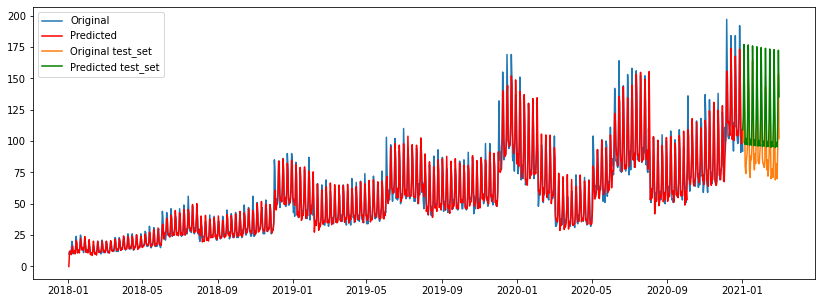

In [40]:
plt.figure(figsize = (14,5))

plt.plot(arima_turno1_train, label = 'Original')
plt.plot(best_result.predict(0, 1095), color = 'red', label = 'Predicted')

plt.plot(arima_turno1_test, label = 'Original test_set')
plt.plot(best_result.predict(1095, 1154), color = 'green', label = 'Predicted test_set')
_ = plt.legend()

In [41]:
print("MAE en el primer mes de predicción: ", mean_absolute_error(arima_turno1_test[:31], best_result.predict(1096, 1126)))
print("MAE en el segundo mes de predicción: ", mean_absolute_error(arima_turno1_test[31:], best_result.predict(1127, 1154)))
print("MAE total: ", mean_absolute_error(arima_turno1_test, best_result.predict(1096, 1154)))

MAE en el primer mes de predicción:  17.859807441050958
MAE en el segundo mes de predicción:  23.605056725305356
MAE total:  20.586366423408975


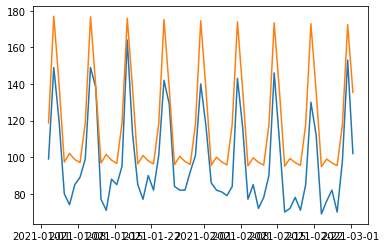

In [42]:
plt.plot(arima_turno1_test, label = 'Original test_set')
_ = plt.plot(best_result.predict(1096, 1154), label = 'Predicted test_set')

#### Ajustando por el nivel de afectación

In [43]:
#Se va a hacer una regresion lineal para predecir cuanto se debe corregir la predicción del modelo arima según su nivel
#de afectación por covid. El objetivo es predecir el valor de y_test-y_pred' y que mejore el MAE
y_train = arima_turno1_train['OrderId'].iloc[730:].values - best_result.predict(730, 1095).values
y_test = arima_turno1_test['OrderId'] - best_result.predict(1096, 1154).values

In [44]:
lr = LinearRegression()
arr = np.reshape(arima_turno1_train['OrderId'].iloc[730:].values, (-1,1))
lr.fit(np.concatenate([adjust_dataframe.iloc[731:1097].values,arr], axis=1), y_train)

LinearRegression()

In [45]:
arr = np.reshape(arima_turno1_test['OrderId'].values, (-1,1))
y_pred = lr.predict(np.concatenate([adjust_dataframe.iloc[1097:1156],arr], axis=1))

In [46]:
mean_absolute_error(arima_turno1_test['OrderId'], best_result.predict(1096, 1154).values+y_pred)

23.199682977250593

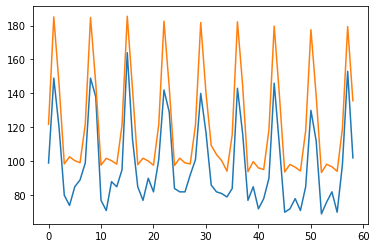

In [47]:
plt.plot(arima_turno1_test.values, label = 'Original')
plt.plot(best_result.predict(1096, 1154).values+y_pred)

Como no mejoran las predicciones ajustando por el umbral se utilizará unicamente el modelo sarimax

### Turno de la tarde

In [48]:
minimum_mae = 100000000

for p in range(1, 12):
    for q in range(1, 12):
        for d in range(2):
            try:
                model = SARIMAX(arima_turno2_train, order = (p,d,q))
                result = model.fit()
                score = mean_absolute_error(arima_turno2_train, result.fittedvalues)
                if score < minimum_mae:
                    best_model2 = model
                    minimum_mae = score
                    best_result = result
                    best_p_2, best_d_2, best_q_2 = (p,d,q)
                print("success! ", p, d, q)
            except:
                print("fail! ", p,d, q)
minimum_mae 

success!  1 0 1
success!  1 1 1
success!  1 0 2
success!  1 1 2
success!  1 0 3
success!  1 1 3
success!  1 0 4
success!  1 1 4
success!  1 0 5
success!  1 1 5
success!  1 0 6
success!  1 1 6
success!  1 0 7
success!  1 1 7
success!  1 0 8
success!  1 1 8
success!  1 0 9
success!  1 1 9
success!  1 0 10
success!  1 1 10
success!  1 0 11
success!  1 1 11
success!  2 0 1
success!  2 1 1
success!  2 0 2
success!  2 1 2
success!  2 0 3
success!  2 1 3
success!  2 0 4
success!  2 1 4
success!  2 0 5
success!  2 1 5
success!  2 0 6
success!  2 1 6
success!  2 0 7
success!  2 1 7
success!  2 0 8
success!  2 1 8
success!  2 0 9
success!  2 1 9
success!  2 0 10
success!  2 1 10
success!  2 0 11
success!  2 1 11
success!  3 0 1
success!  3 1 1
success!  3 0 2
success!  3 1 2
success!  3 0 3
success!  3 1 3
success!  3 0 4
success!  3 1 4
success!  3 0 5
success!  3 1 5
success!  3 0 6
success!  3 1 6
success!  3 0 7
success!  3 1 7
success!  3 0 8
success!  3 1 8
success!  3 0 9
success!  3 1 9


7.2360449622074405

In [49]:
minimum_mae

7.2360449622074405

In [50]:
best_p_2, best_d_2, best_q_2

(8, 1, 11)

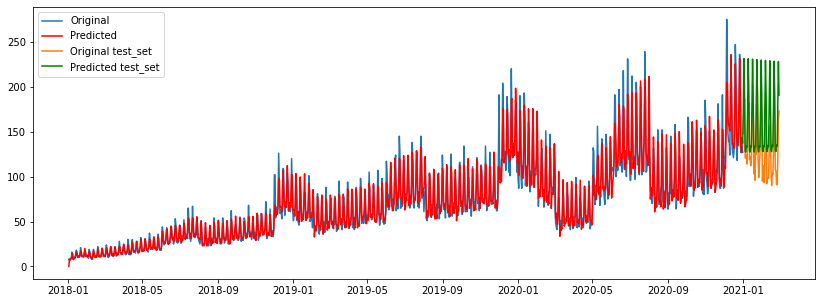

In [51]:
plt.figure(figsize = (14,5))

plt.plot(arima_turno2_train, label = 'Original')
plt.plot(best_result.predict(0, 1095), color = 'red', label = 'Predicted')

plt.plot(arima_turno2_test, label = 'Original test_set')
plt.plot(best_result.predict(1095, 1154), color = 'green', label = 'Predicted test_set')
_ = plt.legend()

In [52]:
print("MAE en el primer mes de predicción: ", mean_absolute_error(arima_turno2_test[:31], best_result.predict(1096, 1126)))
print("MAE en el segundo mes de predicción: ", mean_absolute_error(arima_turno2_test[31:], best_result.predict(1127, 1154)))
print("MAE total: ", mean_absolute_error(arima_turno2_test, best_result.predict(1096, 1154)))

MAE en el primer mes de predicción:  21.33756514108474
MAE en el segundo mes de predicción:  37.957516077910036
MAE total:  29.224999483984877


### Predicción resultado Marzo - 2021
Se sabe que los modelos de series de tiempo van haciendo cada ves peores predicciones. Por lo tanto se volvera a ajustar el modelo con todos los datos hasta marzo de 2021. Se espera que se tenega un error MAE para marzo similar al que se tuvo para el conjunto de testeo cuando el modelo solo fue entrenado con el conjunto de entrenamiento.

#### Turno de la mañana

In [53]:
arima_train_final = pd.concat([arima_turno1_train,arima_turno1_test])

model = SARIMAX(arima_train_final, order = (best_p, best_d, best_q))
result = model.fit()
score = mean_absolute_error(arima_train_final, result.fittedvalues)
print(score)

4.788718673793698


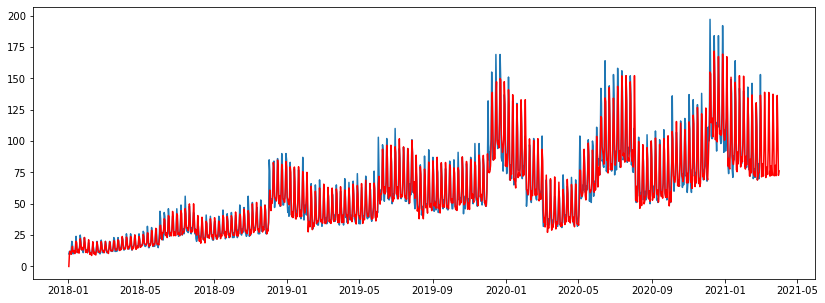

In [54]:
plt.figure(figsize = (14,5))

plt.plot(arima_train_final, label = 'Original')
plt.plot(result.predict(0, 1184), color = 'red', label = 'Predicted')

In [55]:
result.predict(1154, 1184).max()

138.86221356601922

In [56]:
np.ceil(result.predict(1154, 1184).max()/30)

5.0

In [57]:
result.predict(1154, 1184)

2021-03-01 10:00:00    123.771703
2021-03-02 10:00:00     71.406127
2021-03-03 10:00:00     75.692998
2021-03-04 10:00:00     82.014639
2021-03-05 10:00:00     72.014628
2021-03-06 10:00:00     93.849995
2021-03-07 10:00:00    138.862214
2021-03-08 10:00:00    110.098007
2021-03-09 10:00:00     70.864630
2021-03-10 10:00:00     77.256302
2021-03-11 10:00:00     79.374365
2021-03-12 10:00:00     73.336951
2021-03-13 10:00:00     93.726551
2021-03-14 10:00:00    138.720388
2021-03-15 10:00:00    109.147858
2021-03-16 10:00:00     72.008457
2021-03-17 10:00:00     76.395628
2021-03-18 10:00:00     80.348228
2021-03-19 10:00:00     72.512511
2021-03-20 10:00:00     94.788298
2021-03-21 10:00:00    137.340680
2021-03-22 10:00:00    109.409818
2021-03-23 10:00:00     72.241454
2021-03-24 10:00:00     76.305839
2021-03-25 10:00:00     80.622264
2021-03-26 10:00:00     72.296499
2021-03-27 10:00:00     95.382350
2021-03-28 10:00:00    136.324293
2021-03-29 10:00:00    109.446800
2021-03-30 10:

#### Turno de la Tarde 

In [58]:
arima_train_final_2 = pd.concat([arima_turno2_train,arima_turno2_test])

model = SARIMAX(arima_train_final_2, order = (best_p, best_d, best_q))
result = model.fit()
score = mean_absolute_error(arima_train_final_2, result.fittedvalues)
print(score)

7.485439429589857


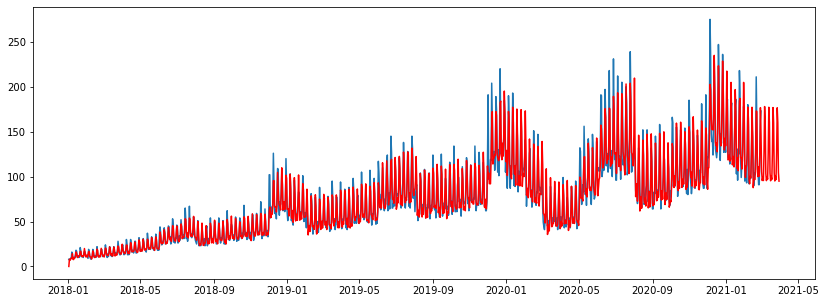

In [59]:
plt.figure(figsize = (14,5))

plt.plot(arima_train_final_2, label = 'Original')
plt.plot(result.predict(0, 1184), color = 'red', label = 'Predicted')

In [60]:
result.predict(1154, 1184).max()

177.95278863578432

In [61]:
np.ceil(result.predict(1154, 1184).max()/30)

6.0

In [62]:
result.predict(1154, 1184)

2021-02-28 15:00:00    146.685788
2021-03-01 15:00:00    105.694347
2021-03-02 15:00:00     95.598010
2021-03-03 15:00:00     99.018740
2021-03-04 15:00:00     95.611677
2021-03-05 15:00:00    126.475171
2021-03-06 15:00:00    177.952789
2021-03-07 15:00:00    160.333343
2021-03-08 15:00:00    103.550674
2021-03-09 15:00:00     95.487947
2021-03-10 15:00:00     99.906510
2021-03-11 15:00:00     97.053208
2021-03-12 15:00:00    126.230054
2021-03-13 15:00:00    177.149509
2021-03-14 15:00:00    160.118413
2021-03-15 15:00:00    103.918836
2021-03-16 15:00:00     95.341577
2021-03-17 15:00:00    100.200250
2021-03-18 15:00:00     96.838619
2021-03-19 15:00:00    126.393266
2021-03-20 15:00:00    176.848613
2021-03-21 15:00:00    160.034052
2021-03-22 15:00:00    104.256651
2021-03-23 15:00:00     95.107693
2021-03-24 15:00:00    100.413269
2021-03-25 15:00:00     96.729873
2021-03-26 15:00:00    126.538983
2021-03-27 15:00:00    176.579831
2021-03-28 15:00:00    159.948864
2021-03-29 15: